In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('sab-bma.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCATTCCACGTTC...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCACAAAATAGGTTGGTCCTCCGTTCTATCTA...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGA...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATGGCGGAGTAAAGCGTGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGGGCTGAGCGCCATTTTGTT...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTAT...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGCTGCATAATGAAACGACAACCTGCTCGTCGC...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 48978.85it/s]


[47, 150, 276, 428, 547, 703, 829, 973, 1137, 1288, 1404, 1540, 1694, 1793, 1977, 2130, 2210, 2331, 2456, 2580, 2633, 2842, 2865, 2969, 3138, 3239, 3312, 3372, 3558, 3650, 3700, 3799, 3922, 3929, 4062, 4143, 4206, 4252, 4275, 4399, 4444, 4488, 4565, 4634, 4693, 4709, 4833, 4751, 4817, 4948, 5024, 4948, 5025, 5123, 5135, 5160, 5108, 5044, 4994, 4921, 4866, 4797, 4756, 4708, 4716, 4636, 4534, 4475, 4434, 4447, 4314, 4303, 4119, 4211, 4067, 3932, 3947, 3839, 3764, 3708, 3590, 3472, 3345, 3270, 3202, 3051, 2967, 2885, 2747, 2641, 2531, 2404, 2311, 2170, 2059, 1958, 1747, 1674, 1548, 1400, 1183, 1107, 965, 831, 700, 537, 387, 218, 135, 34]


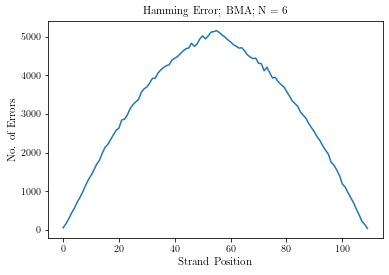

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; BMA; N = 6', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov6-sab-bma-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:17<00:00, 566.35it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


CCC ->  6
TGCG ->  6
CAC ->  6
CC -> T 6
 -> CTCA 6
GA -> CC 6
TTG -> C 6
CG -> TA 6
TGG -> A 6
 -> CACG 6
G -> ATT 6
GGT -> C 6
T -> GAC 6
GCTT ->  6
 -> GAGA 6
TGAC ->  6
CTTG ->  6
CTTA ->  6
 -> CGGT 6
T -> GCG 6
T -> CCG 6
T -> CCCA 6
G -> TT 6
T -> CCC 6
CTCG ->  6
TT -> CC 6
 -> CTAA 6
G -> CTA 6
TA -> CG 6
TTGC ->  6
ATGC ->  6
GC -> TA 6
ATTG ->  6
AAG ->  6
T -> GGC 6
T -> AGC 6
TCG -> A 7
 -> AGAA 7
TCTG ->  7
 -> GAAG 7
TTCA ->  7
 -> AATC 7
GTAC ->  7
GTA -> C 7
 -> TACC 7
 -> CCCC 7
 -> CCAA 7
TAG -> C 7
 -> TGCA 7
TTGG ->  7
ATA ->  7
CAA ->  7
GC -> AT 7
GAT -> C 7
 -> CGAA 7
 -> AACC 7
CTGT ->  7
T -> ACC 7
TAA ->  7
TA -> CC 7
 -> AGTA 7
AA -> C 7
T -> GAAA 7
CTG -> A 7
GA -> CT 7
 -> AAAC 7
CGGT ->  7
CGT -> AA 7
 -> GCGG 7
CCT -> A 8
 -> GAAA 8
CCG ->  8
G -> AAC 8
 -> AAGA 8
CC -> AA 8
CGA ->  8
 -> GTAC 8
GG -> CC 8
CC -> G 8
CCA ->  8
GGT -> A 8
GGTT ->  8
TC -> AG 8
 -> AGGA 8
GTAT ->  8
 -> CAAC 8
T -> ACG 8
T -> CCA 8
 -> CAAA 8
T -> CAG 8
AA -> T 9
AAC ->  9


 -> ACA @ 56 6
C -> G @ 48 6
GC ->  @ 70 6
 -> GC @ 46 6
C -> G @ 42 6
TA ->  @ 30 6
G -> AA @ 56 6
A -> C @ 18 6
 -> GC @ 53 6
C -> G @ 33 6
C -> G @ 32 6
T -> CC @ 54 6
 -> T @ 105 6
 -> GAC @ 55 6
C -> AT @ 54 6
TT ->  @ 80 6
TT ->  @ 81 6
TA ->  @ 32 6
GG ->  @ 43 6
T -> AG @ 54 6
A -> C @ 39 6
C -> G @ 59 6
TG ->  @ 68 6
GA ->  @ 55 6
G -> T @ 59 6
 -> AAT @ 55 6
 -> CG @ 52 6
TT ->  @ 40 6
 -> TA @ 53 6
AT ->  @ 65 6
AT ->  @ 73 6
C -> G @ 80 6
AT ->  @ 74 6
A -> C @ 82 6
G -> T @ 76 6
GC ->  @ 51 6
 -> AC @ 41 6
T -> G @ 5 6
 -> AC @ 59 6
 -> AC @ 66 6
GC ->  @ 57 6
 -> GCC @ 53 6
TT ->  @ 53 6
 -> CA @ 51 6
GG ->  @ 47 6
G -> T @ 77 6
G -> T @ 61 6
A -> C @ 41 6
GG ->  @ 55 6
A -> C @ 63 6
TA ->  @ 45 6
GT ->  @ 84 6
CT ->  @ 54 6
GT ->  @ 38 6
C -> A @ 109 6
GT ->  @ 72 6
A -> C @ 72 6
A -> C @ 73 6
TC ->  @ 97 6
A -> C @ 91 6
TC ->  @ 88 6
GT ->  @ 68 6
 -> G @ 106 6
GT ->  @ 66 6
TC ->  @ 71 6
TC ->  @ 55 6
TC ->  @ 66 6
 -> G @ 109 6
GT ->  @ 49 6
TC ->  @ 60 6
 -> CTG @ 55

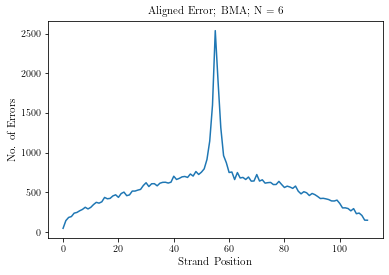

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; BMA; N = 6', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov6-sab-bma-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[0, 25, 32, 28, 44, 41, 55, 58, 44, 43, 58, 46, 57, 49, 48, 63, 67, 47, 54, 63, 70, 50, 62, 62, 61, 56, 73, 60, 75, 66, 76, 50, 69, 73, 74, 73, 57, 56, 65, 61, 72, 70, 86, 51, 61, 63, 65, 69, 72, 61, 66, 77, 59, 45, 72, 99, 112, 77, 58, 68, 67, 75, 65, 72, 57, 78, 59, 77, 50, 62, 70, 57, 65, 56, 68, 66, 47, 65, 81, 55, 54, 68, 56, 66, 59, 54, 50, 67, 58, 54, 65, 63, 51, 62, 42, 53, 51, 54, 71, 55, 49, 49, 50, 49, 36, 48, 33, 42, 51, 30, 32]
[18, 20, 32, 29, 23, 34, 24, 25, 28, 35, 37, 42, 36, 37, 44, 33, 35, 32, 44, 46, 34, 46, 40, 40, 49, 62, 41, 53, 44, 56, 55, 55, 46, 57, 57, 58, 61, 64, 62, 52, 57, 58, 53, 57, 62, 65, 58, 74, 63, 60, 49, 64, 79, 96, 129, 243, 156, 88, 65, 66, 68, 63, 53, 55, 51, 53, 65, 79, 62, 61, 64, 53, 70, 55, 71, 52, 63, 51, 54, 75, 46, 48, 55, 58, 59, 46, 45, 40, 60, 47, 46, 42, 44, 45, 47, 41, 27, 42, 39, 36, 34, 32, 27, 23, 21, 32, 20, 26, 24, 18, 11]
[0, 28, 22, 26, 26, 30, 38, 40, 34, 34, 35, 21, 33, 38, 33, 43, 53, 45, 40, 52, 26, 47, 52, 44, 54, 49, 49,

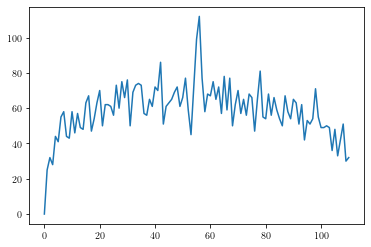

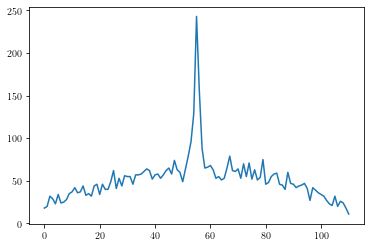

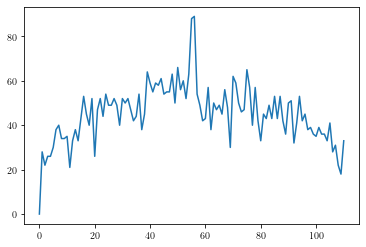

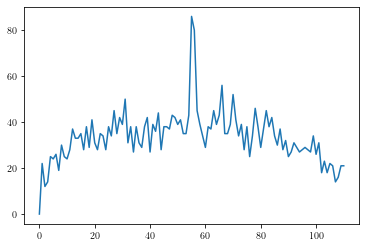

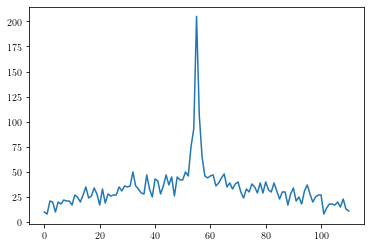

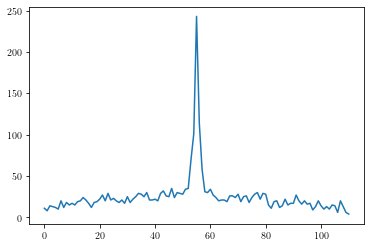

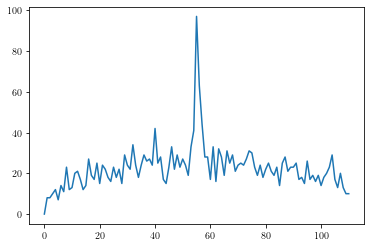

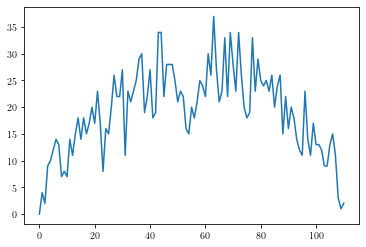

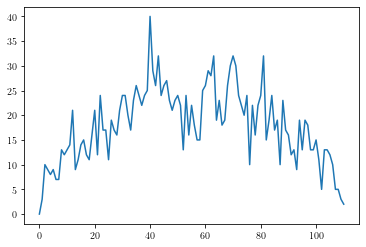

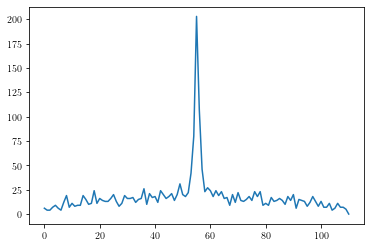

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)